### Image

In [ ]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

In [85]:
kernel = np.ones((20,20), np.uint8)
img_dil = cv2.dilate(img, kernel, iterations=1)
img_dil = (img_dil*0.5).astype(np.uint8)
img_res = cv2.add(img, img_dil)


kernel1 = np.ones((40,40), np.uint8)
img_dil1 = cv2.dilate(img, kernel1, iterations=1)
img_dil1 = (img_dil1*0.3).astype(np.uint8)
img_res = cv2.add(img_res, img_dil1)

kernel2 = np.ones((80,80), np.uint8)
img_dil2 = cv2.dilate(img, kernel2, iterations=1)
img_dil2 = (img_dil2*0.1).astype(np.uint8)
img_res = cv2.add(img_res, img_dil2)

### DBSCAN

In [180]:
img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

gray = img
blur = cv2.blur(gray, (3, 3)) # blur the image
ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)

In [183]:
np.unique(thresh)

array([  0, 255], dtype=uint8)

In [209]:
from sklearn.cluster import DBSCAN

x = np.where(thresh==255)
X = np.vstack((x[0], x[1])).T

output = DBSCAN(eps=10, min_samples=2).fit(X)

In [210]:
set(output.labels_)
x[1].shape

(18817,)

In [211]:
output.labels_
X.shape

(18817, 2)

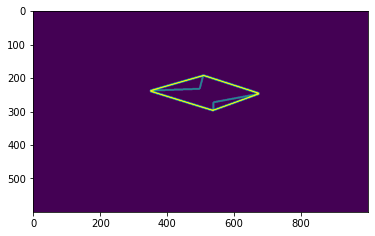

In [303]:
tmp_img = np.zeros((600,1000)).astype(np.uint8)
x1 = X[np.where(output.labels_==1), :][0]
for xy in x1:
    tmp_img[xy[0], xy[1]] = 255

plt.imshow(tmp_img, cmap='gray')

contours, hierarchy = cv2.findContours(tmp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_show = np.zeros((600,1000), dtype=np.uint8)
img_show = cv2.drawContours(img_show, contours, -1, 125, 3)

hull = cv2.convexHull(contours[0])
img_show = cv2.drawContours(img_show, [hull], -1, 255, 3)
plt.imshow(img_show)

### Lidar point

In [169]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.cluster import DBSCAN
import cv2
from sklearn.linear_model import LinearRegression
import time

data = np.load('data.npy', allow_pickle=True)
X = []
rads = np.linspace(0,2*np.pi,1972)
for i,rad in enumerate(rads):
    if data[i] < 4:
        # X.append([data[i], rad])
        X.append([data[i]*np.cos(rad), data[i]*np.sin(rad)])
X = np.array(X)
X.shape

(227, 2)

0.002208709716796875


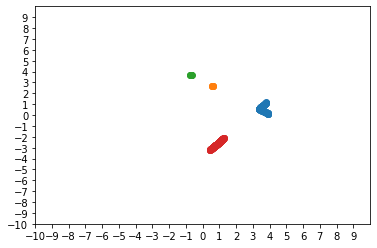

In [170]:
t1 = time.time()
clus = DBSCAN(eps=0.5, min_samples=5).fit(X).labels_ 
print(time.time() -t1)
fig, ax = plt.subplots()
ax.set(xlim=(-10,10), xticks=np.arange(-10,10),
       ylim=(-10,10), yticks=np.arange(-10,10))
for id in set(clus):
    Xi = X[np.where(clus==id)]
    ax.scatter(Xi[:,0], Xi[:,1])
plt.show()

-38.493258585673026
51.506741414326974
0.001859426498413086


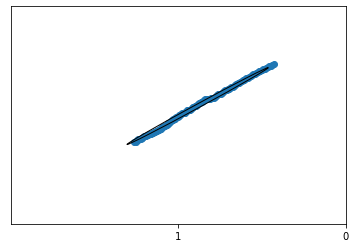

In [182]:
def find_hull(xy, scale=100, lim=400):
    xy_ = np.int32(xy*scale)+lim
    img = np.zeros((2*lim,2*lim)).astype(np.uint8)
    img[xy_[:,1], xy_[:,0]] = 255
    # img = cv2.flip(img, 0)

    kernel = np.ones((5,5))
    img = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((3,3))
    img = cv2.erode(img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        print('num of contour', len(contours))
    # img_show = cv2.drawContours(img.copy(), contours, -1, 255, 3)
    hull = cv2.convexHull(contours[0])
    # img_show = cv2.drawContours(img.copy(), [hull], -1, 255, 3)
    hull = hull.reshape((-1,2))
    hull = (hull-lim)/scale
    return hull

def find_circle(xy):
    center = np.mean(xy, axis=0)
    dist = np.linalg.norm(xy-center, axis=1)
    r = np.max(dist)
    return center, r

def hull2ellipse(hull, n_std=2.0):
    cov = np.cov(hull[:,0], hull[:,1])
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)*np.sqrt(cov[0, 0]) * n_std
    ell_radius_y = np.sqrt(1 - pearson)*np.sqrt(cov[1, 1]) * n_std

    w,v = np.linalg.eig(cov)
    vmax = v[np.argmin(w)]
    # rot = np.arctan(vmax[1]/vmax[0])
    # print(vmax)
    # print(np.arctan(vmax[1]/vmax[0])*180/np.pi)
    rot = np.rad2deg(np.arctan2(vmax, [1,0])[0])
    print(rot)
    if rot > 0:
        rot = 90 - rot
    else:
        rot += 90
    print(rot)
    ellipse = Ellipse(np.mean(hull, axis=0), width=ell_radius_x * 2, height=ell_radius_y * 2, fill=False, angle=rot)
    return ellipse

fig, ax = plt.subplots()
# ax.set(xlim=(-4,4), xticks=np.arange(-4,4),
#         ylim=(-4,4), yticks=np.arange(-4,4))

# ax.set(xlim=(-10,10), xticks=np.arange(-10,10),
#        ylim=(-10,10), yticks=np.arange(-10,10))

ax.set(xlim=(2,0), xticks=np.arange(0,2),
        ylim=(-1,-4), yticks=np.arange(-1,-4))

t1 = time.time()
for i in set(clus):
    xy = X[np.where(clus==3)]
    ax.scatter(xy[:,0], xy[:,1])
    ellipse = hull2ellipse(xy, n_std=2.0)
    ax.add_patch(ellipse)
    break
print(time.time() - t1)
plt.show()